## Clone GitHub Repo

In [1]:
## Check if the repo already exist and cd into it
import os

directory_name = "Neccton_Super_Resolution"
# Check if we are not already in the directory
if os.path.basename(os.getcwd()) != directory_name:
    # If not, check if the repo already exist
    if not os.path.exists(directory_name):
      # if not clone it
      !git clone https://github.com/AntoineBernigaud/Neccton_Super_Resolution.git
    # Move into the directory
    %cd Neccton_Super_Resolution

/content/Neccton_Super_Resolution


## Donwload the data:
- High resolution fields for validation
- Low resolution upsampled fields as an input of the neural network
- The High resolution land mask
- The weights of the NN

In [3]:
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/LR_upsampled/restart.2015_004_00_0000.a -P data/LR_upsampled/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/LR_upsampled/restart.2015_004_00_0000.b -P data/LR_upsampled/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/restart.2015_004_00_0000.a -P data/Residuals/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/restart.2015_004_00_0000.b -P data/Residuals/

!wget -nc ftp://ftp.nersc.no/reddaml/neccton/residuals/tp5mask.npy -P data/Residuals/
!wget -nc ftp://ftp.nersc.no/reddaml/neccton/Model_weights/Checkpoints.h5 -P Weights/

File ‘data/LR_upsampled/restart.2015_004_00_0000.a’ already there; not retrieving.
File ‘data/LR_upsampled/restart.2015_004_00_0000.b’ already there; not retrieving.
File ‘data/Residuals/restart.2015_004_00_0000.a’ already there; not retrieving.
File ‘data/Residuals/restart.2015_004_00_0000.b’ already there; not retrieving.
File ‘data/Residuals/tp5mask.npy’ already there; not retrieving.
File ‘Weights/Checkpoints.h5’ already there; not retrieving.


## Install necessary dependancies, import the necessary modules and define plot functions

In [4]:
!pip install netCDF4==1.5.8

from data_generator3V2 import Data_generator, generate_dates, convert_date_format, \
                            load_standardization_data
from models.attention_res_net3V2 import Att_Res_UNet
import tensorflow as tf
import re
import numpy as np
import numpy.ma as ma
import abfile
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%load_ext autoreload


def extract_name_and_number(input_string):
    """
    Extracts the name and number from a string in a specific format.
    (Used to get the name and layer number of a predictor out of a list of predictors).
    Args:
        input_string (str): The input string to be processed.

    Returns:
        tuple or None: A tuple containing the extracted name and number,
        or (None, None) if the input string doesn't match the expected format.
    """
    # Define a pattern for the desired format
    pattern = re.compile(r'^(.+)-(layer|cat)-(\d+)$')

    # Match the pattern against the input string
    match = pattern.match(input_string)

    # Check if the pattern matches
    if match:
        # Extract the name and number from the matched groups
        name = match.group(1)
        number = match.group(3)
        return name, number
    else:
        # Return None if the input string doesn't match the expected format
        return None, None



def plot_fld(vname,fld,max_abs_val = None, min_abs_val = None):
    """
    Plot field data

    Args:
        vname (str): The name of the variable being plotted.
        fld (numpy.ndarray): The field data to be plotted.
        max_abs_val (float, optional): The maximum absolute value for color scale.
            If None, maximum absolute value in `fld` is used. Defaults to None.
        min_abs_val (float, optional): The minimum absolute value for color scale.
            If None, minimum absolute value in `fld` is used. Defaults to None.
    Returns:
        None
    """
    f, (ax1) = plt.subplots(1, 1, figsize=(11, 11))
    if (max_abs_val is None) and (min_abs_val is None):
        max_abs_val = np.max(fld)
        min_abs_val = np.min(fld)
    P=ax1.pcolormesh(fld, vmin=min_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

cmap = plt.colormaps["bwr"]
cmap.set_bad('gray')

def plot_res(vname,fld,max_abs_val = None) :
    """
    Plot residual data with a red/white/blue centered at 0 color colorbar.

    Args:
        vname (str): The name of the variable being plotted.
        fld (numpy.ndarray): The field data to be plotted.
        max_abs_val (float, optional): The maximum absolute value for color scale.
            If None, maximum absolute value in `fld` is used. Defaults to None.
    Returns:
        None
    """
    f, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
    if max_abs_val is None:
        max_abs_val = np.max(np.abs(fld))
    P = ax1.pcolormesh(fld, cmap=cmap, vmin=-max_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

## Define the dates to perform the super resolution and define the path to access the data

In [5]:
# Minimum and maximum date to perform the super-resolution
date_min_test = '2015_004'
date_max_test = '2015_004'

days_range = 7 # number of days between two predictions
dates_test = generate_dates(date_min_test, date_max_test, days_range)
print('date list of testing days:')
print(dates_test)
print(f'number of testing days: {len(dates_test)}')

# Define the path for the data
paths = {}
root_data_dir = 'data'
# Path to the low resolution upsampled data and residuals data
paths["data_residuals"] = os.path.join(root_data_dir,"Residuals")
paths["data_LR_upsampled"] = os.path.join(root_data_dir,"LR_upsampled")
# Path to the standardization files containing the mean / variance of the field
# for normalization
paths["standard"] = root_data_dir
file_standardization_res = os.path.join(paths["data_residuals"],"standard_residuals.h5")
file_standardization_LR_upsampled = os.path.join(paths["data_LR_upsampled"],"standard_LR_upsampled.h5")

# Path for the model weights
paths["model_weights"] = 'Weights/'
file_model_weights = os.path.join(paths["model_weights"],"Checkpoints.h5")

date list of testing days:
['2015_004']
number of testing days: 1


## Define the Predictors and the parameters for the test

In [7]:
# Load standardization files
standard_LR_upsampled = load_standardization_data(file_standardization_LR_upsampled)
standard_res = load_standardization_data(file_standardization_res)

# the predictors must have the name "fieldname-layer-layernumber", except for the land
# mask called "tp5_mask"
list_predictors = ["temp-layer-1", "temp-layer-2", "temp-layer-3", "temp-layer-4", "temp-layer-5",
                    "temp-layer-6", "temp-layer-7", "temp-layer-8", "temp-layer-9", "temp-layer-10",
                    "tp5_mask"]
list_targets = ["temp-layer-1"]

# Model Parameters
model_params = {"list_predictors": list_predictors,
                "list_targets": list_targets,
                "dim": (760, 800), # (jdm,idm)
                "cropped_dim": (768, 800), #
                "batch_size": 1,
                "n_filters": [32*(i+1) for i in range(6)],
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }
# Testing Parameters
params_test = {"list_predictors": model_params["list_predictors"],
                "list_labels": model_params["list_targets"],
                "list_dates": dates_test,
                "standard_res": standard_res,
                "standard_LR_upsampled": standard_LR_upsampled,
                "batch_size": model_params["batch_size"],
                "path_data_res": paths["data_residuals"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":1,
                }
#
model_and_compile_params = {**model_params, **params_test}

## Initialize the Neural Network

In [8]:
# Initialization of the data generator (used to load the data dynamically into the memory)
# and of the Neural network
test_generator = Data_generator(**params_test)
unet_model = Att_Res_UNet(**model_params).make_unet_model()
unet_model.load_weights(file_model_weights)

## Prediction of the HR field

In [9]:
# Prediction on the first element of the first batch
predict_batch = unet_model.predict(test_generator[0][0]) # prediction on test_generator['batch_number']['LR field upsampled']

# Choose a target number (for now only possible to choose the only target number 0)
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
# Get the field corresponding to the chosen target in the prediction
predict = predict_batch[0,:,:,target_no]
# Crop the prediction to match the dimension of the real field
predict = predict[0:760,:]
# Same thing for the input (X) and the truth (y)
X_batch, y_batch = test_generator[0]
X = X_batch[0,...,target_no]
y = y_batch[0,...,target_no]
X = X[0:760,:]
y = y[0:760,:]

1/1 [==============================] - 10s 10s/step


In [10]:
# Denormalization function (the NN predicts has normalized the outputs)

def denormalize(standard, var_name, layer, var_data):
    """
    Denormalizes the given variable data based on the provided normalization parameters.

    Args:
        standard (dict): Dictionary containing normalization parameters.
        var_name (str): Name of the variable to denormalize.
        layer (int): Layer index.
        var_data (numpy.ndarray): Normalized data to be denormalized.

    Returns:
        numpy.ndarray: Denormalized data.
    """
    denorm_data = var_data * (standard[var_name][layer]["max"] - standard[var_name][layer]["min"]) + standard[var_name][layer]["min"]
    return denorm_data

# Denormalize the prediction and the truth and mask them with the land mask

y = denormalize(standard_res, target_name, target_layer, y)
predict = denormalize(standard_res, target_name, target_layer, predict)

tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)

# Same with the input

X = denormalize(standard_LR_upsampled, target_name, target_layer, X)
X = np.ma.masked_array(X,tp5mask)

prediction_reconstructed = X + predict # Add the prediction of the residuals to the input to get the full predicted field
Truth_reconstructed = X+y # Add the prediction of the residuals to the truth to get the full HR true field

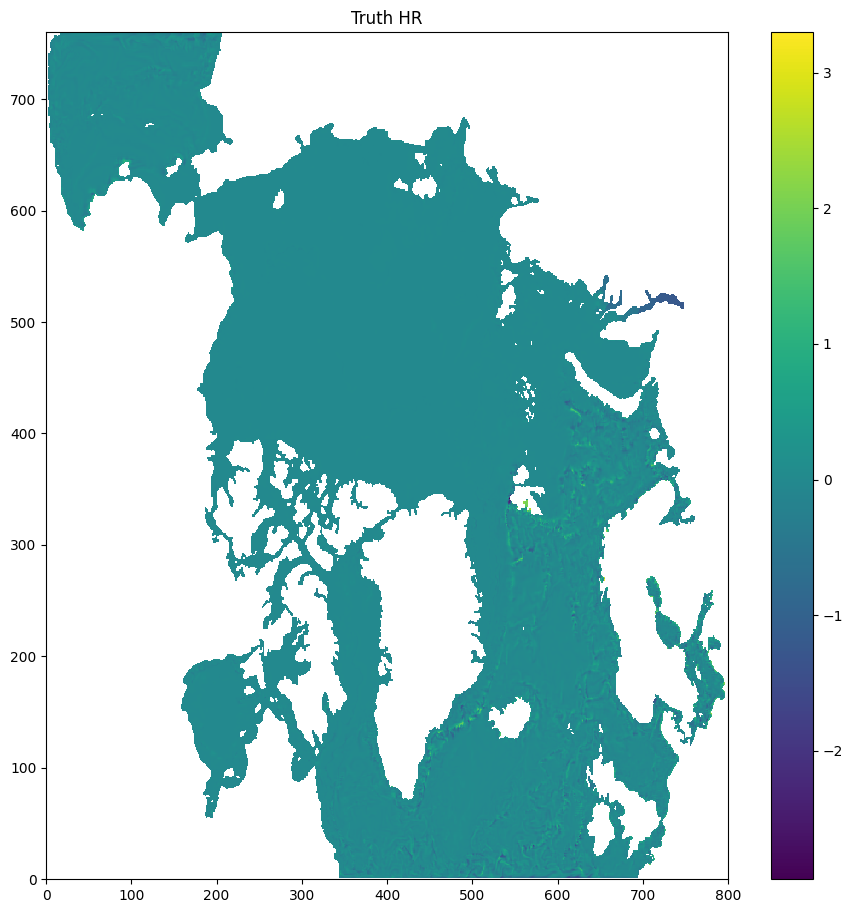

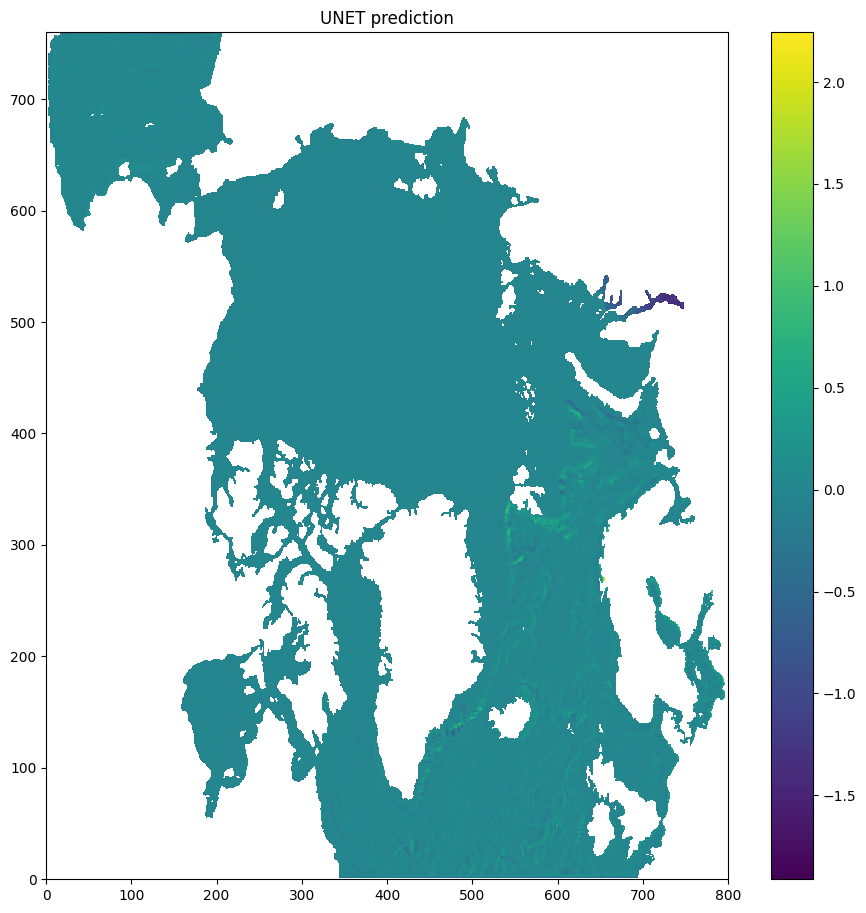

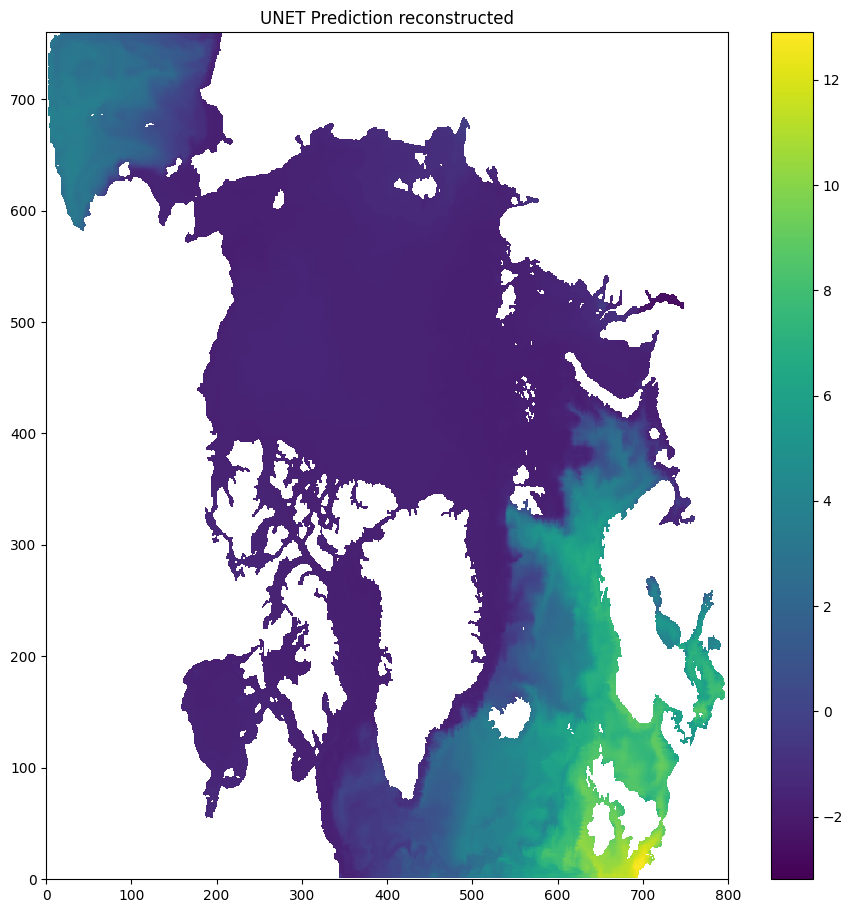

In [11]:
plot_fld('Truth HR', y)
plot_fld('UNET prediction', predict)
plot_fld('UNET Prediction reconstructed', prediction_reconstructed)

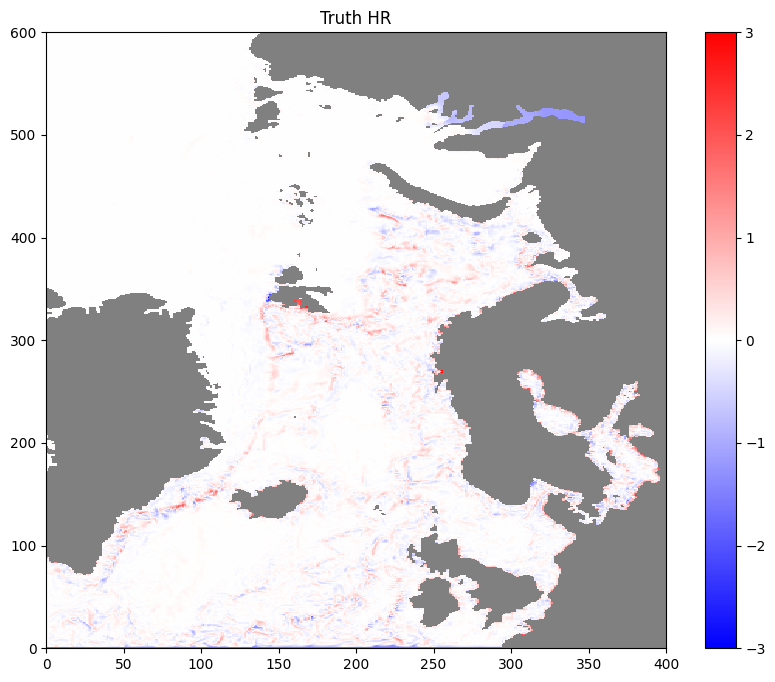

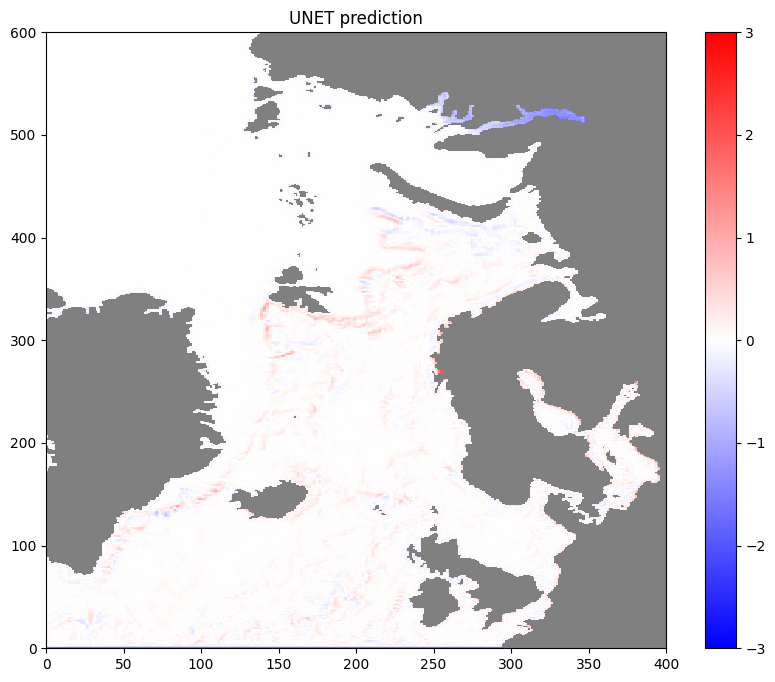

In [12]:
plot_res('Truth HR', y[0:600,400:800], 3)
plot_res('UNET prediction', predict[0:600,400:800], 3) #np.max(y), np.min(y))

## Comparison against baseline with different metrics

Bias between Unet prediction and truth: 4.5827e-03
Bias between Bilinear interpolation and truth: 4.5828e-03
Bias: Unet Prediction has the better result.

MSE between Unet prediction and truth: 1.1872e-02
MSE between Bilinear interpolation and truth 1.6278e-02
MSE: Unet Prediction has the better result.

PSNR Unet prediction 155.161
PSNR  Bilinear interpolation 152.005
PSNR: Unet Prediction has the better result.



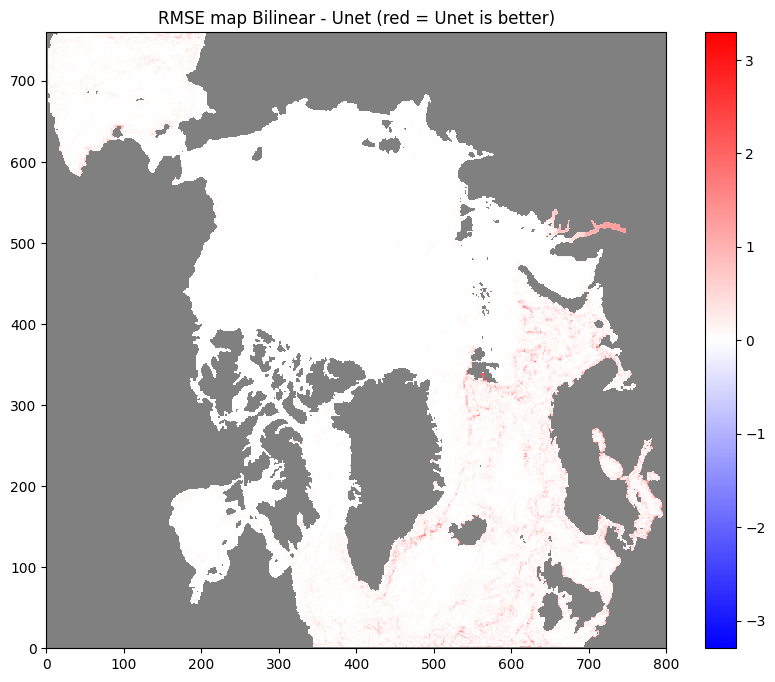

In [13]:
# Compute bias
bias_pred = np.mean(y) - np.mean(predict)
bias_interp = np.mean(y)
print('Bias between Unet prediction and truth: {:.4e}'.format(bias_pred))
print('Bias between Bilinear interpolation and truth: {:.4e}'.format(bias_interp))
if abs(bias_pred) < abs(bias_interp):
    bias_result = "Unet Prediction"
else:
    bias_result = "Bilinear Interpolation"
print('Bias:', bias_result, 'has the better result.')
print()

# MSE
mse_upsample = np.mean(np.square(y)) # truth - LR_upsampled = truth - X = y
mse_unet = np.mean(np.square(y - predict)) # truth - prediction_reconstructed = y + X - (pred + X) = y - pred
print('MSE between Unet prediction and truth: {:.4e}'.format(mse_unet))
print('MSE between Bilinear interpolation and truth {:.4e}'.format(mse_upsample))
if mse_upsample > mse_unet:
    mse_result = "Unet Prediction"
else:
    mse_result = "Bilinear Interpolation"
print('MSE:', mse_result, 'has the better result.')
print()

# Peak Signal to Noise Ration
psnr_upsample = 10*np.log(255**2/mse_upsample)
psnr_unet = 10*np.log(255**2/mse_unet)
print('PSNR Unet prediction {:.3f}'.format(psnr_unet))
print('PSNR  Bilinear interpolation {:.3f}'.format(psnr_upsample))
if psnr_unet > psnr_upsample:
    psnr_result = "Unet Prediction"
else:
    psnr_result = "Bilinear Interpolation"
print('PSNR:', psnr_result, 'has the better result.')
print()

#RMSE MAP
RMSE_MAP_upsample = np.sqrt(np.square(y))
RMSE_MAP_unet = np.sqrt(np.square(y - predict))
RMSE_MAP = RMSE_MAP_upsample - RMSE_MAP_unet # Red means RMSE_MAP_upsample > RMSE_MAP_unet
                                             # meaning better results for the Unet
plot_res('RMSE map Bilinear - Unet (red = Unet is better)',RMSE_MAP_upsample)

In [14]:
# SSIM loss (requires to get the normalized images)

# Get the normalized images
target_no = 0
target_name, target_layer = extract_name_and_number(list_targets[target_no])
target_layer = int(target_layer)
predict = predict_batch[0,:,:,target_no]
predict = predict[0:760,:]
X_batch, y_batch = test_generator[0] ## True data
X = X_batch[0,...,target_no] ## first 0 -> sample number in the batch ... last 0 -> predictor number
y = y_batch[0,...,target_no]
X = X[0:760,:]
y = y[0:760,:]

# Impose masks
tp5mask = np.load(os.path.join(paths["data_residuals"],'tp5mask.npy') )
y = np.ma.masked_array(y,tp5mask)
predict = np.ma.masked_array(predict,tp5mask)
X = np.ma.masked_array(X,tp5mask)

truth = y + X
prediction_reconstructed = predict + X

# Turn into tf.tensor and add a 3rd dimension to use the tf.ssim function
# NB: WHEN CONVERTING A MASK ARRAY TO TF_TENSOR, THE MASK BECOME 0
tf_truth = tf.convert_to_tensor(truth, dtype=tf.float32)
tf_prediction_reconstructed = tf.convert_to_tensor(prediction_reconstructed, dtype=tf.float32)
tf_X = tf.convert_to_tensor(X, dtype=tf.float32)

tf_truth = tf_truth[..., tf.newaxis]
tf_prediction_reconstructed = tf_prediction_reconstructed[..., tf.newaxis]
tf_X = tf_X[..., tf.newaxis]

ssim_upsample = tf.image.ssim_multiscale(tf_truth, tf_X, max_val=1.0)
ssim_unet = tf.image.ssim_multiscale(tf_truth, tf_prediction_reconstructed, max_val=1.0)
print('SSIM between Unet prediction and truth: {:.3f}'.format(ssim_unet))
print('SSIM between Bilinear interpolation and truth {:.3f}'.format(ssim_upsample))
if ssim_unet > ssim_upsample:
    mse_result = "Unet Prediction"
else:
    mse_result = "Bilinear Interpolation"
print('SSIM:', mse_result, 'has the better result.')
print()

SSIM between Unet prediction and truth: 0.649
SSIM between Bilinear interpolation and truth 0.619
SSIM: Unet Prediction has the better result.

